# Maxim Kondakov

In [ ]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, length, when, col, broadcast
from pyspark.sql.types import BooleanType, IntegerType, LongType, StringType, ArrayType, FloatType, StructType, StructField
import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader


In [ ]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import date_format
from pyspark.sql.functions import weekofyear
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
import pandas as pd
import seaborn as sns

In [ ]:
# setting constants
APP_NAME = "YOUR_APP_NAME"
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = "-Dlog4j.configuration=file://{} -Dspark.hadoop.dfs.replication=1 -Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"\
    .format(LOG4J_PROP_FILE)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [ ]:
# preparing configuration files from templates
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template\
    .stream(logfile=LOG_FILE)\
    .dump(LOG4J_PROP_FILE)

In [ ]:
# run spark
spark = SparkSession\
    .builder\
    .appName(APP_NAME)\
    .master("k8s://https://10.32.7.103:6443")\
    .config("spark.driver.host", LOCAL_IP)\
    .config("spark.ui.port", "4040")\
    .config("spark.kubernetes.memoryOverheadFactor", "0.6")\
    .config("spark.driver.memory", "4g")\
    .config("spark.driver.bindAddress", "0.0.0.0")\
    .config("spark.executor.instances", "5")\
    .config("spark.executor.cores", '4')\
    .config("spark.executor.memory", "5g")\
    .config("spark.memory.fraction", "0.6")\
    .config("spark.memory.storageFraction", "0.5")\
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")\
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)\
    .config("spark.kubernetes.namespace", "mkondakov-310009")\
    .config("spark.kubernetes.driver.label.appname", APP_NAME)\
    .config("spark.kubernetes.executor.label.appname", APP_NAME)\
    .config("spark.kubernetes.container.image.pullPolicy", "Always")\
    .config("spark.kubernetes.container.image", "node03.st:5000/spark-executor:mkondakov-310009")\
    .config("spark.kubernetes.executor.deleteOnTermination", "true")\
    .config("spark.local.dir", "/tmp/spark")\
    .getOrCreate()

In [ ]:
! hdfs dfs -put detect_12.json /home/mkondakov-310009/detect_12.json

In [ ]:
JSON_SCHEMA = StructType([
    StructField('_id', StructType([
        StructField('$oid', StringType())
    ])),
    StructField('x', IntegerType()),
    StructField('y', IntegerType()),
    StructField('z', IntegerType()),
    StructField('time_detected', FloatType()),
    StructField('object_id', IntegerType()),
    StructField('category', StringType()),
    StructField('clf_category', StringType()),
    StructField('conf', FloatType()),
    StructField('picked', BooleanType()),
    StructField('proceed', StructType([
        StructField('proceed_1', StringType()),
        StructField('proceed_2', StringType()),
    ])),
    StructField('repeated_detection', ArrayType(StructType([
        StructField('time_detected', FloatType()),
        StructField('x', IntegerType()),
        StructField('y', IntegerType()),
        StructField('z', IntegerType()),
        StructField('category', StringType()),
        StructField('clf_category', StringType()),
        StructField('conf', FloatType())
    ])))
])
df = spark.read.json('/home/mkondakov-310009/detect_12.json', multiLine=True, schema=JSON_SCHEMA)

## convert  unix time

In [ ]:
time_df = df.select("time_detected","object_id")\
    .withColumn("py_date", F.from_unixtime('time_detected'))\
    .drop("time_detected")

time_df = time_df.select('py_date',"object_id", date_format('py_date', 'E').alias('day_week'),weekofyear(time_df.py_date).alias('num_week'))
time_df.show(3)

+-------------------+---------+--------+--------+
|            py_date|object_id|day_week|num_week|
+-------------------+---------+--------+--------+
|2021-05-15 16:29:52|        0|     Sat|      19|
|2021-05-15 16:29:52|        1|     Sat|      19|
|2021-05-15 16:29:52|        2|     Sat|      19|
+-------------------+---------+--------+--------+
only showing top 3 rows



In [ ]:
row = time_df.select(F.min('py_date').name("min_date"), F.max('py_date').name("max_date")).first() # alternatively apply .collect()
row

Row(min_date='2021-05-15 16:29:52', max_date='2021-06-08 11:05:36')

## all items

In [ ]:
df_picked = df.select("category", 'object_id',"time_detected")\
.where("picked == true")\
.withColumn("py_date", F.from_unixtime('time_detected'))\
.withColumn("day_week",  date_format('py_date', 'E'))\
.withColumn("day_of_week",  date_format('py_date', 'F'))\
.withColumn("day_of_year",  date_format('py_date', 'D'))\
.drop("time_detected")

df_picked = df_picked.withColumn("num_week", weekofyear(df_picked.py_date))
df_picked.show(3)

+-------------+---------+-------------------+--------+-----------+-----------+--------+
|     category|object_id|            py_date|day_week|day_of_week|day_of_year|num_week|
+-------------+---------+-------------------+--------+-----------+-----------+--------+
|TRANSP BOTTLE|      122|2021-05-15 16:32:00|     Sat|          1|        135|      19|
|  BLUE BOTTLE|      136|2021-05-15 16:32:00|     Sat|          1|        135|      19|
|TRANSP BOTTLE|      138|2021-05-15 16:32:00|     Sat|          1|        135|      19|
+-------------+---------+-------------------+--------+-----------+-----------+--------+
only showing top 3 rows



## Top 5 all items

In [ ]:
pl_df = df.groupby("category")\
    .agg(F.count("category").name("object_count"))\
    .orderBy("object_count", ascending=False)\

pl_df.show(5)

+--------------+------------+
|      category|object_count|
+--------------+------------+
|          CANS|      166175|
|   BLUE BOTTLE|      108776|
| TRANSP BOTTLE|      101130|
|MILK CARDBOARD|       60024|
|  GREEN BOTTLE|       38201|
+--------------+------------+
only showing top 5 rows



In [ ]:
all_category_df = pl_df.toPandas()

In [ ]:
some_values2 = ['CANS','BLUE BOTTLE','TRANSP BOTTLE','MILK CARDBOARD','GREEN BOTTLE']
qwe = all_category_df.loc[all_category_df['category'].isin(some_values2)]

<AxesSubplot:xlabel='category', ylabel='object_count'>

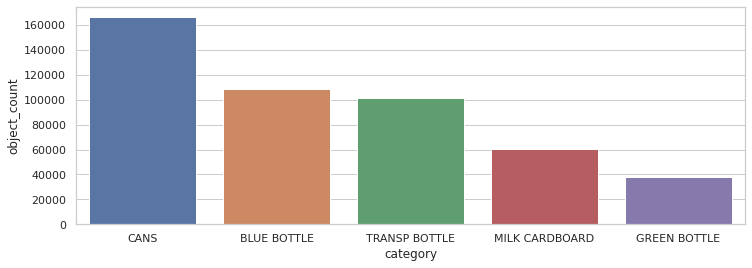

In [ ]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="category", y="object_count", data=qwe)


 ## Top 5 items picked

In [ ]:
count_by_category = df_picked.groupby("category")\
    .agg(F.count("category").name("object_count"))\
    .orderBy("object_count", ascending=False)\

count_by_category.show(5)

+-------------+------------+
|     category|object_count|
+-------------+------------+
|TRANSP BOTTLE|       28093|
|  BLUE BOTTLE|       20899|
| GREEN BOTTLE|        9635|
|  DARK BOTTLE|        3750|
|    5L BOTTLE|        2036|
+-------------+------------+
only showing top 5 rows



<AxesSubplot:xlabel='category', ylabel='object_count'>

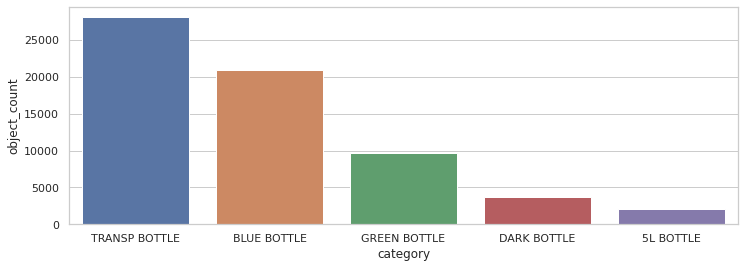

In [ ]:
count_by_category_df = count_by_category.toPandas()
qwe = count_by_category_df.loc[count_by_category_df['category'].isin(some_values)]

fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="category", y="object_count", data=qwe)

## stat analysis

In [ ]:
pandas_picked = df_picked.toPandas()
picked_df = pandas_picked.groupby(['category', 'day_of_year']).size().reset_index(name='counts')
picked_df.sort_values('day_of_year', inplace=True)

In [ ]:
some_values = ['TRANSP BOTTLE','BLUE BOTTLE','GREEN BOTTLE','DARK BOTTLE','5L BOTTLE']
qwe = picked_df.loc[picked_df['category'].isin(some_values)]
qwe.head()

,category,day_of_year,counts
0,5L BOTTLE,135,101
23,BLUE BOTTLE,135,1004
46,DARK BOTTLE,135,74
161,GREEN BOTTLE,135,448
207,TRANSP BOTTLE,135,1133


In [ ]:
qwe[qwe["category"]== 'DARK BOTTLE'].describe()

,counts
count,23.000000
mean,163.043478
std,50.970114
min,43.000000
25%,146.000000
50%,168.000000
75%,192.500000
max,235.000000


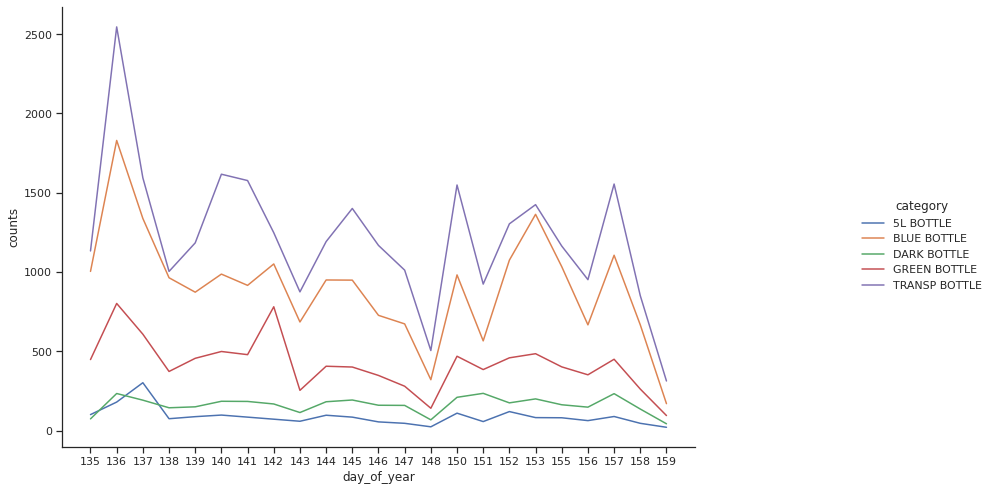

In [ ]:
g = sns.relplot(
    data = qwe,
    x="day_of_year",y="counts", hue="category",kind="line")
g.fig.set_size_inches(15,7)